In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,root_mean_squared_error
from sklearn.metrics import r2_score
import optuna
import seaborn as sns

filename = 'ahs2021n.csv'
forced_binary_vars = ['detached', 'trailer', 'white', 'black', 'asian', 'hispanic', 'hs_grad', 'bachelors', 'grad_school']
        #Lots of data is stored categorically, eg. BLD represents whether a house is detached
        #but also number of units in an apartment, so i break them up into binaries in the data processing
        #each needs to be encoded seperately, so they are handled apart from the binary vars
binary_vars = ['SOLAR','ADEQUACY','ROOFSAG','ROOFHOLE','NHQSCHOOL','NHQPCRIME','NHQSCRIME','FS','INTSTATUS','TENURE']
sel_vars = ['HINCP_log','YRBUILT', 'BEDROOMS', 'HHMOVE','TOTROOMS','NUMPEOPLE','HHAGE','MARKETVAL']
sel_vars = sel_vars + binary_vars + forced_binary_vars

First, I set up variable names that will be used when reading in data. As we are trying to predict housing price, MARKETVAL is the Y variable, while the rest are X variables. I have divided the variables into sel_vars, which are all non-binary and non-categorical, forced_binary, which are categorical in the dataset, but I have manually handled to create binary variables, eg, for race, and binary variables, which are binary in the dataset.

In [2]:
def clean_and_convert_to_int(s):
    cleaned_string = s.strip("'")
    return (int(cleaned_string.lstrip('0')) if cleaned_string != '0' else 0)


In [3]:
chunks = []
for chunk in pd.read_csv(filename, chunksize=1000):
        # Processing each chunk
    df = chunk.copy()  # Make a copy to avoid modifying the original chunk

        # Perform necessary modifications
        # Filtering binary values
    for var in binary_vars:
        df.loc[:, var] = df[var].apply(lambda x: clean_and_convert_to_int(x))
        df.loc[df[var] == 'N', var] = 1
        df.loc[df[var] != 1, var] = 0
    categorical_cols = ['BLD','HHRACE','HHSPAN','HHGRAD']
    for var in categorical_cols:
        df.loc[:, var] = df[var].apply(lambda x: clean_and_convert_to_int(x))
        
    df['HINCP'] = np.where(df['HINCP'] < 1, 1, df['HINCP'])
    df['HINCP_log'] = np.log(df['HINCP'])

        # Create additional binary variables
    df['detached'] = np.where(df['BLD'] == 2, 1, 0)
    df['trailer'] = np.where(df['BLD'] == 1, 1, 0)
    df['white'] = np.where(df['HHRACE'] == 1, 1, 0)
    df['black'] = np.where(df['HHRACE'] == 2, 1, 0)
    df['asian'] = np.where(df['HHRACE'] == 4, 1, 0)  
    df['hispanic'] = np.where(df['HHSPAN'] == 1, 1, 0)
    df['hs_grad'] = np.where((df['HHGRAD'] == 39) | (df['HHGRAD'] == 41), 1, 0)
    df['bachelors'] = np.where(df['HHGRAD'] == 41, 1, 0)
    df['grad_school'] = np.where(df['HHGRAD'].isin([45, 46, 47]), 1, 0)
        #filter only owner occupied units to get the housing costs
    df =  df[(df['INTSTATUS'] == 1) & (df['TENURE'] == 1)]
        # Filter the DataFrame based on sel_vars
    for var in binary_vars + forced_binary_vars:
        df[var] = df[var].astype('category')
    df = df[sel_vars]
        
        # Append the modified chunk to the list of chunks
    chunks.append(df)
df = pd.concat(chunks, ignore_index=True)

Here, I load in the data by chunks of 1000 rows. Then, I clean categorical data on race and housing type by creating binary variables out of them and converting their values to integers. Then, because we are predicting house value, I filter to only owner-occupied units, because those are the only ones where the market price variable, MARKETVAL, is available. I take the log of HINCP, monthly income, because there may be very high variability and outliers.

DESCRIPTIVE STATISTICS
          HINCP_log       YRBUILT      BEDROOMS        HHMOVE      TOTROOMS  \
count  31669.000000  31669.000000  31669.000000  31669.000000  31669.000000   
mean      11.019739   1973.108403      3.217689   2004.899334      6.435473   
std        1.761581     26.642212      0.896945     14.490474      1.588505   
min        0.000000   1919.000000      0.000000   1936.000000      1.000000   
25%       10.616437   1950.000000      3.000000   1997.000000      5.000000   
50%       11.314475   1980.000000      3.000000   2009.000000      6.000000   
75%       11.867097   1990.000000      4.000000   2017.000000      7.000000   
max       15.342436   2021.000000      5.000000   2021.000000     13.000000   

          NUMPEOPLE         HHAGE     MARKETVAL      ADEQUACY       ROOFSAG  \
count  31669.000000  31669.000000  3.166900e+04  31669.000000  31669.000000   
mean       2.590862     56.850800  4.446941e+05      0.967381      0.016136   
std        1.435377     15.6

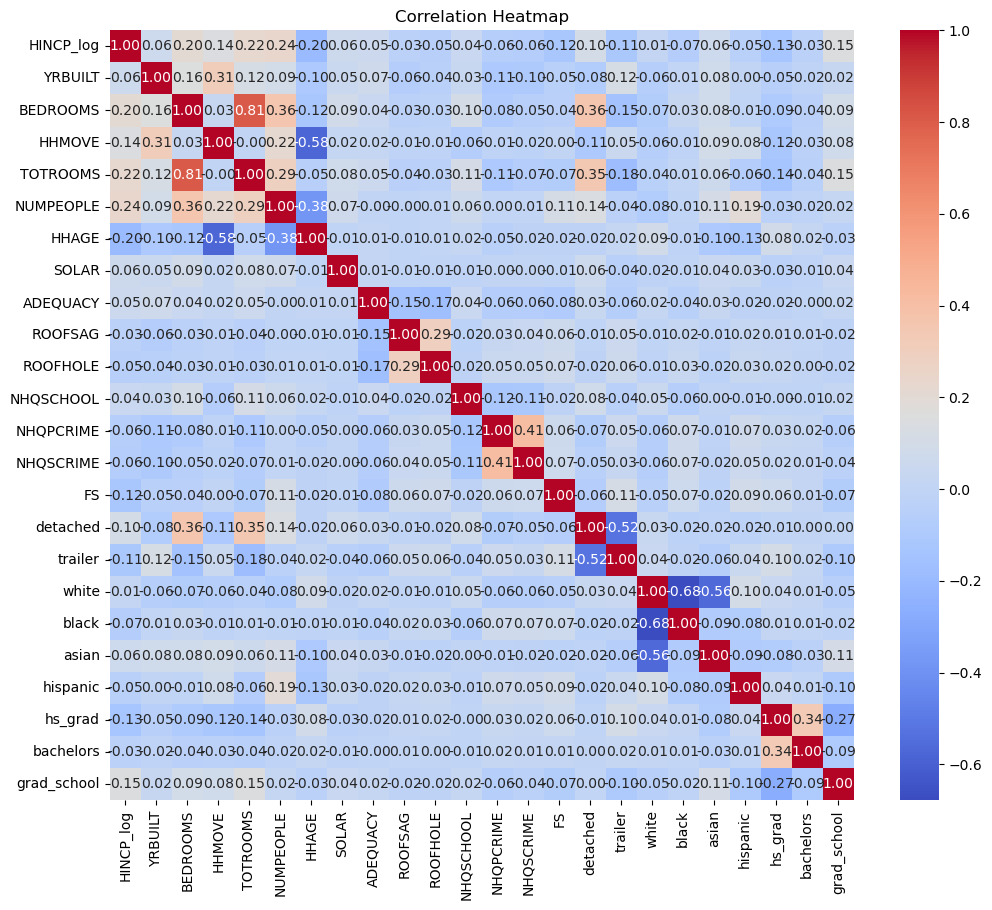

In [4]:
print('DESCRIPTIVE STATISTICS')
print(df.describe())
x_vars = [i for i in sel_vars if i not in ('MARKETVAL', 'INTSTATUS', 'TENURE')]
# Assign x variables
x = df[x_vars]        
correlation_matrix = x.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Here, I use a correlation heatmap to see if there are issues with multicollinerity in the dataset, as well as the performance of the various models in dealing with these issues. Apart from expected interactions(eg. being white is highly negatively correlated with being black), most interactions are expected. It may be useful to note the negative correlations between trailer homes and number of rooms, as well as the reverse issue being present for detached houses. 

In [5]:
def residuals_plot(fitted_values,residual,model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(fitted_values, residual, color='blue')
    plt.title(f'Residuals vs Fitted, {model_name}')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.grid(True)
    plt.show()

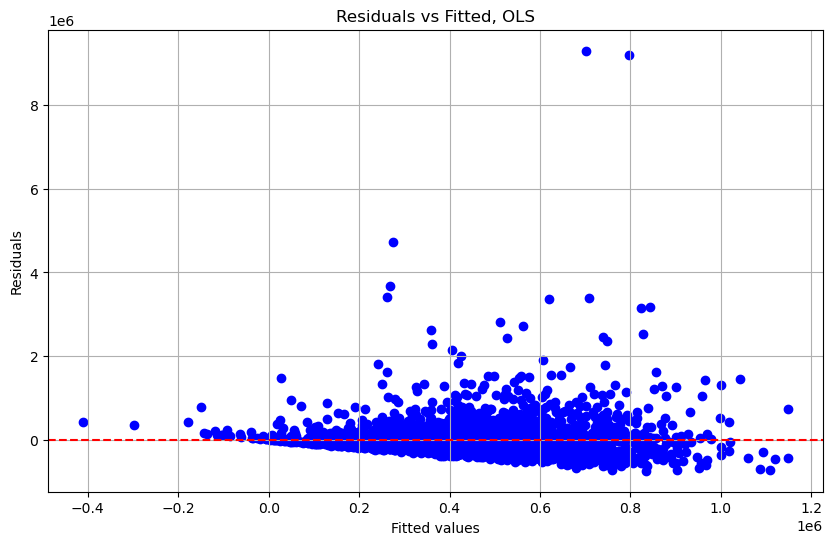

                            OLS Regression Results                            
Dep. Variable:              MARKETVAL   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     175.7
Date:                Sun, 07 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:32:56   Log-Likelihood:            -4.1386e+05
No. Observations:               28502   AIC:                         8.278e+05
Df Residuals:                   28477   BIC:                         8.280e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.235e+06   5.18e+05     -2.387      

In [11]:
model_name = 'OLS'
X = df[x_vars]    
y = df['MARKETVAL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
# Fit the OLS model
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
    
    # Make predictions on the test set
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)
residuals = y_test - y_pred
residuals_plot(y_pred, residuals, 'OLS')
    # Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
    
    # Print model summary and evaluation metrics
print(model.summary())
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")




The OLS model shows the strongest predictors(via t hypothesis test) of a houses market value are whether or not a house has solar panels, its number of rooms, if it is a trailer, and the log monthly income of the head of household. Some variables, like race, education levels, and household size, have high positive or negative coefficients, but t tests close to 0, indicating low signficiance. The residual plot indicates a skew in the linear model; it is weaker in predicting the values of more expensive houses based on the owners. This is discussed in more depth looking at the expected vs. actual values of the Random Forest Regression.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

    # Define lambda values
lambda_list = [10 ** exp for exp in range(-7, 4)]
param_grid = {'alpha': lambda_list}

    # Create Ridge regression model
ridge_reg = linear_model.Ridge()

    # Perform grid search with 10 fold cross-validation, minimizing MSE
grid_search = GridSearchCV(ridge_reg, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

    # Get the best estimator from grid search
best_ridge_reg = grid_search.best_estimator_

    # Make predictions using the best estimator
y_pred = best_ridge_reg.predict(X_test)

print('RIDGE MODEL SUMMARY')
    # Print model coefficients
print("Model Coefficients:")
for var, coef in zip(x_vars, best_ridge_reg.coef_):
    print(f"{var}: {coef}")

    # Print intercept
print("Intercept:", best_ridge_reg.intercept_)

    # Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

    # Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

    # Calculate R-squared
r_squared = best_ridge_reg.score(X_test, y_test)
print("R-squared:", r_squared)

    # Print the best lambda value
print("Best Lambda (alpha):", grid_search.best_params_['alpha'])


RIDGE MODEL SUMMARY
Model Coefficients:
HINCP_log: 16731.738839651553
YRBUILT: -720.2219431938578
BEDROOMS: 29900.155609197947
HHMOVE: 1178.9195537427765
TOTROOMS: 55035.06208684069
NUMPEOPLE: 2369.351862457888
HHAGE: 2282.653209630454
SOLAR: 213842.0543773219
ADEQUACY: 42675.781227139945
ROOFSAG: -70627.264115746
ROOFHOLE: 32336.667201530665
NHQSCHOOL: 8234.720900940807
NHQPCRIME: 21926.822559744247
NHQSCRIME: -312.9268961887172
FS: -84261.69649656744
detached: -74778.29176114888
trailer: -236529.01760596197
white: -21659.82859435191
black: -122942.3767036572
asian: 182068.46189597234
hispanic: 96.4214652921566
hs_grad: -73196.77511383565
bachelors: 41776.65781500952
grad_school: 125956.04758353437
Intercept: -1241895.651423624
Mean Squared Error (MSE): 196046668380.9043
Root Mean Squared Error (RMSE): 442771.5758502394
R-squared: 0.13867596904160884
Best Lambda (alpha): 10


The ridge regression results are highly similar to the OLS results, possibly due to the very large sample size. Although there are some variable selection effects (lambda = 10), the testing split of y exhibits an r^2 value of .138, as compared to .129 for OLS. Although the t test values are not shown, the coefficients of this model are very similar to the OLS model.

In [9]:

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    rf_model = RandomForestRegressor(**params, random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [10]:
# Split data into train and test sets (10% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Set up Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params

# Train the model with the best hyperparameters
rf_best = RandomForestRegressor(**best_params, random_state=42)
rf_best.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_best.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"Best Hyperparameters: {best_params}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


[I 2024-04-05 11:29:34,760] A new study created in memory with name: no-name-b4328383-3391-40f9-ac96-640edf26fccd


[I 2024-04-05 11:29:51,445] Trial 0 finished with value: 177757973694.0609 and parameters: {'n_estimators': 660, 'max_depth': 12, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 177757973694.0609.
[I 2024-04-05 11:29:54,911] Trial 1 finished with value: 183397001449.06107 and parameters: {'n_estimators': 278, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 177757973694.0609.
[I 2024-04-05 11:30:00,854] Trial 2 finished with value: 177157013388.08896 and parameters: {'n_estimators': 205, 'max_depth': 15, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 2 with value: 177157013388.08896.
[I 2024-04-05 11:31:01,146] Trial 3 finished with value: 181479382563.8695 and parameters: {'n_estimators': 701, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 2 with value: 177157013388.08896.
[

Best Hyperparameters: {'n_estimators': 703, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Mean Absolute Error (MAE): 217978.11
Root Mean Squared Error (RMSE): 417156.92


c:\Users\aadit\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Here, I set up an objective function that creates a random forest object,  then optimizes number of estimators objects, maximum tree depth, minimum samples required in a split, minimum samples required for a leaf, and maximum number of features(as a function of sample sizes) via grid search. Due to the techincal limitations of my laptop, an exhaustive random grid search was too computationally intense, so I utilized the optuna library in Python, which uses previous iterations of the grid search to efficiently test more likely hyperparameters based on the performance of previous iterations. After 50 iterations of the grid search, the optimal hyperparameters are as follows:
n_estimators': 703, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'
This model performed better than the OLS and Ridge regressions.


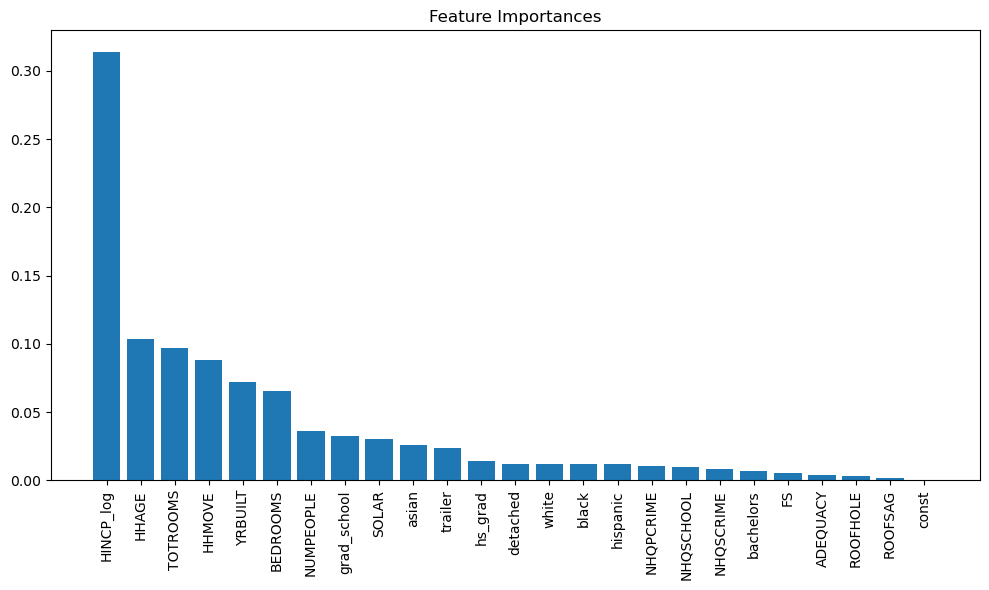

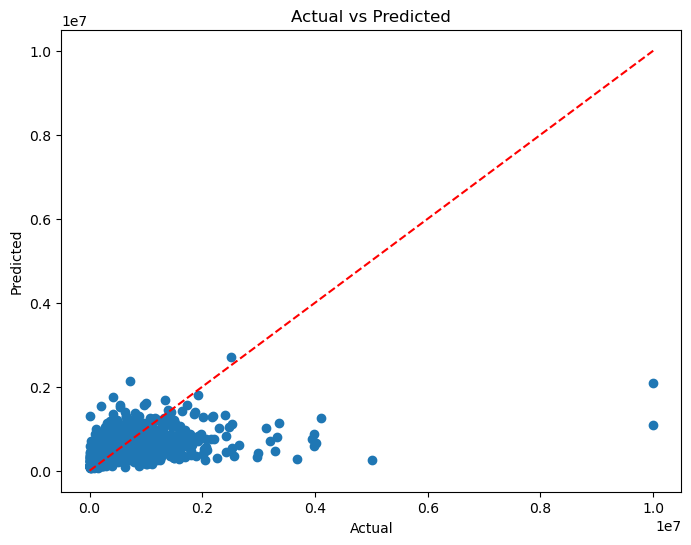

'\n# Visualization: Partial Dependence Plot (PDP) for one feature (change feature_idx accordingly)\nfrom sklearn.inspection import plot_partial_dependence\nfeature_idx = 0  # Change this index according to the feature you want to plot\nplot_partial_dependence(rf_best, X_train, features=[feature_idx])\nplt.show()\n'

In [11]:
# Visualization: Feature Importance
feature_importances = rf_best.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

# Visualization: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

These vizualizations illustrate the performance of the Random Forest model and importances of each feature. In the first plot, log-tranformed monthly income(HINCP_log) has the strongest performance, followed by the age of the house and the number of rooms in the house. A strength of the model is in its treatment of binary variables. Some features, like FS(if the household head is on food stamps) or ROOFHOLE have very low feature importance, but their coefficients in the linear model are large, indicating that they are a very small part of the sample, but have a strong negative effect when present. The Actual vs Predicted plot indicates the weakness of this model, which it shares with the OLS and ridge regressions. Accuracy deteriorates as true income increases, which is visible through the skew of data points towards the left-hand side of the plot. This indicates that high-income people are more likely to live in smaller houses than low/middle income are to live in larger houses. This logic seems reasonable, as real estate is a market with high frictions and the 'market value' of a house may not accurately capture the utility gained from a given house, eg. due to location, family needs, environmental concerns, and emotional value. Additionally, a very expensive house may have more variable simply because the negotiable range of values is less objectively measurable, in part due to the above mentioned factors.